<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/CatBoost_Testing_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports:**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import getpass
import datetime
import sklearn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
from google.colab import drive

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.utils import class_weight

import lightgbm as lgb
import xgboost as xgb

from seaborn import heatmap

# for satellite picture
!pip install earthpy
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# for Oversampling and Augmentation
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN



     |████████████████████████████████| 1.4MB 4.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0MB 26.7MB/s 
     |████████████████████████████████| 19.3MB 1.4MB/s 
     |████████████████████████████████| 15.4MB 198kB/s 
     |████████████████████████████████| 6.6MB 41.8MB/s 
  Created wheel for earthpy: filename=earthpy-0.9.2-cp37-none-any.whl size=1365096 sha256=faa2301accac1ce474a799ac9880024d060b286e1c92ece224cfef67a76eca79
  Stored in directory: /root/.cache/pip/wheels/27/f9/a5/026bb95ef7b12f9343b842da6897b4001c5b902550095cbbbe
Successfully built earthpy


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# mount Google Drive
if 'Tom' not in getpass.getuser():
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load train and test set
data = np.load('train.npz') if 'Tom' in getpass.getuser() else np.load('/content/gdrive/MyDrive/Colab Notebooks/train.npz') 
test_data = np.load('public_test.npz') if 'Tom' in getpass.getuser() else np.load('/content/gdrive/MyDrive/Colab Notebooks/public_test.npz')

In [ ]:
## TRAIN data
# separate bands and labels:
train_data_raw = data['bands']
labels_raw = data['lulc']

In [ ]:
## TEST data
# extract data:
X_test_raw_shape = test_data['bands']
X_test_raw_shape.shape

(12, 500, 500, 6)

In [ ]:
# add class labels manually
classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])
classes_without_empty_labels=np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Artificial Surface', 'Bareland'])
classes_without_no_data = np.array(['Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

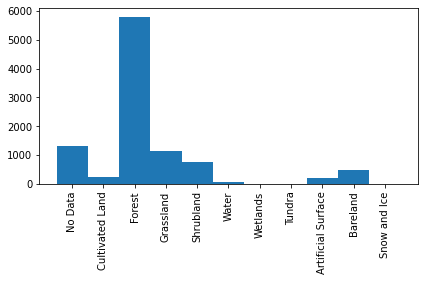

In [ ]:
# Class distribution:
plt.hist(labels_raw, bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

# **Preprocessing:**

Do not use data points with "no data" as label:

In [ ]:
# Get indices where label = no data:
no_data_indices = labels_raw != 0

# Exclude them from training set:
train_data = train_data_raw[no_data_indices]
labels = labels_raw[no_data_indices]
print(train_data.shape)

(8692, 12, 33, 33, 6)


Extract Center Points from 33x33 Patches

In [ ]:
# extract middle pixel data for each patch:
train_data_center_points_month_and_channel = train_data[:,:,16,16,:]
train_data_center_points_month_and_channel.shape

num_data_points = 8692

In [ ]:
# reshape training data:
# results in [channel1_jan, channel2_jan, ..., channel6_jan, channel1_feb, ...]
train_data_center_points = train_data_center_points_month_and_channel.reshape((num_data_points,72))
train_data_center_points.shape

#print(train_data[42,:,16,16,:])
#print(train_data_center_points[42,])

# Varify that value for 42nd patch in November for fourth band for central Pixel is the same in raw train data and reshaped train data
print(train_data[42,10,16,16,3])
print(train_data_center_points[42,10*6+3])
print(train_data_center_points.shape)

0.1736
0.1736
(8692, 72)


**Augmentation and Oversampling:**

---



In [ ]:
# choose from following methods: smote, adasyn, smote_enn, smote_tomek

methodStr = "adasyn"

# SMOTE Data Augmentation
method = SMOTE()
if methodStr == "smote":
  method = SMOTE()  # Data Augmentation by synthezising data until balanced
elif methodStr == "adasyn":
  method = ADASYN() #
elif methodStr == "smote_enn":
  method = SMOTEENN(random_state=0) # Combination of Under- and Oversampling
elif methodStr == "smote_tomek":
  method = SMOTETomek(random_state=0) # Combination of Under- and Oversampling 

train_data_center_points_oversample, labels_oversample = method.fit_resample(train_data_center_points, labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

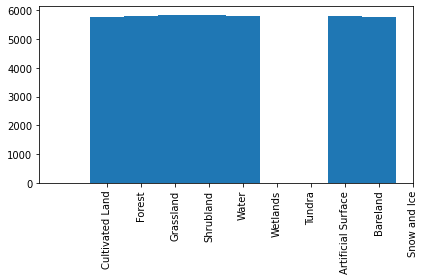

In [ ]:
# SMOTE Preprocessing Class distribution:
plt.hist(labels_oversample, bins=list(range(len(classes_without_no_data) + 1)))
plt.xticks(ticks=list(map(lambda x: x+1.5, list(range(len(classes_without_no_data))))), labels=classes_without_no_data, rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Over Sampling Data Balancing

ros = RandomOverSampler()
train_data_ROS, labels_ROS = ros.fit_resample(train_data_center_points, labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


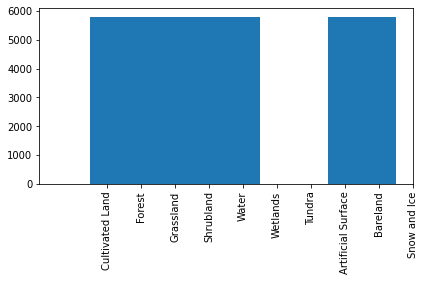

In [ ]:
# ROS Balancing Class distribution:
plt.hist(labels_ROS, bins=list(range(len(classes_without_no_data) + 1)))
plt.xticks(ticks=list(map(lambda x: x+1.5, list(range(len(classes_without_no_data))))), labels=classes_without_no_data, rotation=90)
plt.tight_layout()
plt.show()

**Preprocessing (continued):**

In [ ]:
# Split data into train and val set:
X_train, X_val, y_train, y_val = train_test_split(train_data_center_points_oversample, labels_oversample, 
                                                    test_size=0.25, stratify = labels_oversample, random_state=42)

In [ ]:
## reshape test data:
# move months to third axis:
print(X_test_raw_shape.shape)

X_test_raw_axis_order_changed = np.moveaxis(X_test_raw_shape,0,-2)
print(X_test_raw_axis_order_changed.shape)

# combine pixel x and y axes:
X_test_raw_axis_combined= X_test_raw_axis_order_changed.reshape((250000, 6, 12))
print(X_test_raw_axis_combined.shape)

# combine channel and month axes:
X_test= X_test_raw_axis_combined.reshape((250000, 72))
print(X_test.shape)


# Varify that value in November for fourth band for Pixel(X=100, Y=42) is the same in raw test data and reshaped test data
print(X_test_raw_shape[10,100,42,3])
print(X_test[100*500+42,10*6+3])

(12, 500, 500, 6)
(500, 500, 12, 6)
(250000, 6, 12)
(250000, 72)
1.0212
1.0212


Extracting average/median values of surrounding pixels:

In [ ]:
# extract neighbor pixels for each patch:
train_data_central_pixels_only = train_data[:,:,16:19,16:19,:]
train_data_central_pixels_only.shape

(8692, 12, 3, 3, 6)

In [ ]:
# compute mean along side pixel axes (3rd and 4th axis)
pixel_means = np.mean(train_data_central_pixels_only, axis=(2,3))


# Check if everything is working as intended:
print(train_data_central_pixels_only[42,10,:,:,4].mean())
print(pixel_means[42,10,4])

0.07723334
0.07723333


In [ ]:
# create list of numpy array with surrounding pixels:
pixel_sets = []
# close pixels (distances 1)
for i in range(1,2):
  pixel_sets.append(train_data[:,:,17-i:17+i,17-i:17+i,:])
# further fixels (distances 5, 15):
#for i in range(5,20,10):
#  pixel_sets.append(train_data[:,:,17-i:17+i,17-i:17+i,:])


# distances 1 - 17:
#for i in range(1,18):
#  pixel_sets.append(train_data[:,:,17-i:17+i,17-i:17+i,:])

In [ ]:
# compute means for each of the sets:
pixel_sets_mean = [np.mean(pixel_set, axis=(2,3)) for pixel_set in pixel_sets]

In [ ]:
# combine month and channel data by reshaping: (10000,72)
pixel_sets_mean_reshaped = [np.reshape(pixel_set,(num_data_points,72)) for pixel_set in pixel_sets_mean]

In [ ]:
# combine sets:
sets_combined = np.concatenate(pixel_sets_mean_reshaped, axis=1)
print(sets_combined.shape)

# combine sets with central pixels:
all_combined = np.concatenate((sets_combined, train_data_center_points), axis=1)
print(all_combined.shape)

(8692, 72)
(8692, 144)


In [ ]:
# Split data into train and val set:
X_train_v2, X_val_v2, y_train_v2, y_val_v2 = train_test_split(all_combined, labels, 
                                                    test_size=0.25, stratify = labels, random_state=42)
print(X_train_v2.shape)
print(y_train_v2.shape)

(6519, 144)
(6519,)


Split up into data for each month:

In [ ]:
X_train_e1, X_val_e1, y_train_e1, y_val_e1 = train_test_split(train_data_center_points_month_and_channel, labels, 
                                                    test_size=0.25, stratify = labels, random_state=42)

In [ ]:
# create list of input variables for each month:
X_train_monthly = [X_train_e1[:,month,:] for month in range(12)]
X_val_monthly = [X_val_e1[:,month,:] for month in range(12)]
y_train_monthly = y_train_e1
y_val_monthly = y_val_e1

# **CatBoost:**

In [ ]:
# install and import catboost library
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:
# create model
# cbm = CatBoostClassifier(learning_rate=0.1, iterations=1000, random_seed=0, logging_level='Verbose', task_type="GPU")
cbm = CatBoostClassifier(learning_rate=0.1, iterations=1000, random_seed=0, logging_level='Verbose')
# fit model
cbm.fit(X_train, y_train)

0:	learn: 1.7870290	total: 222ms	remaining: 3m 41s
1:	learn: 1.6675469	total: 432ms	remaining: 3m 35s
2:	learn: 1.5706204	total: 637ms	remaining: 3m 31s
3:	learn: 1.4854885	total: 852ms	remaining: 3m 32s
4:	learn: 1.4195209	total: 1.04s	remaining: 3m 26s
5:	learn: 1.3549671	total: 1.25s	remaining: 3m 27s
6:	learn: 1.3000880	total: 1.47s	remaining: 3m 28s
7:	learn: 1.2495634	total: 1.7s	remaining: 3m 31s
8:	learn: 1.2069930	total: 1.94s	remaining: 3m 33s
9:	learn: 1.1708648	total: 2.14s	remaining: 3m 32s
10:	learn: 1.1417943	total: 2.35s	remaining: 3m 31s
11:	learn: 1.1124886	total: 2.57s	remaining: 3m 31s
12:	learn: 1.0860714	total: 2.76s	remaining: 3m 29s
13:	learn: 1.0610498	total: 2.97s	remaining: 3m 29s
14:	learn: 1.0402162	total: 3.16s	remaining: 3m 27s
15:	learn: 1.0203563	total: 3.34s	remaining: 3m 25s
16:	learn: 1.0004997	total: 3.58s	remaining: 3m 26s
17:	learn: 0.9852613	total: 3.77s	remaining: 3m 25s
18:	learn: 0.9692135	total: 3.98s	remaining: 3m 25s
19:	learn: 0.9556117	to

In [ ]:
# Predict labels for test data
cbm_predictions = cbm.predict(X_val)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_val, cbm_predictions)*100}")
print(f"F1-Score: {f1_score(y_val, cbm_predictions, average=None)*100}")
print(classification_report(y_val, cbm_predictions))

Accuracy: 95.72498029944838
F1-Score: [98.22161423 91.0784665  92.81767956 91.29395698 99.93103448 98.93871962
 97.58749575]
              precision    recall  f1-score   support

           1       0.97      1.00      0.98      1440
           2       0.95      0.88      0.91      1449
           3       0.94      0.92      0.93      1462
           4       0.91      0.92      0.91      1457
           5       1.00      1.00      1.00      1449
           8       0.98      1.00      0.99      1451
           9       0.96      0.99      0.98      1444

    accuracy                           0.96     10152
   macro avg       0.96      0.96      0.96     10152
weighted avg       0.96      0.96      0.96     10152



In [ ]:
cbm_predictions = cbm_predictions.reshape(-1)
cbm_predictions[0:20]

array([8, 5, 3, 2, 1, 9, 1, 2, 1, 9, 4, 4, 8, 9, 9, 2, 8, 3, 4, 9])

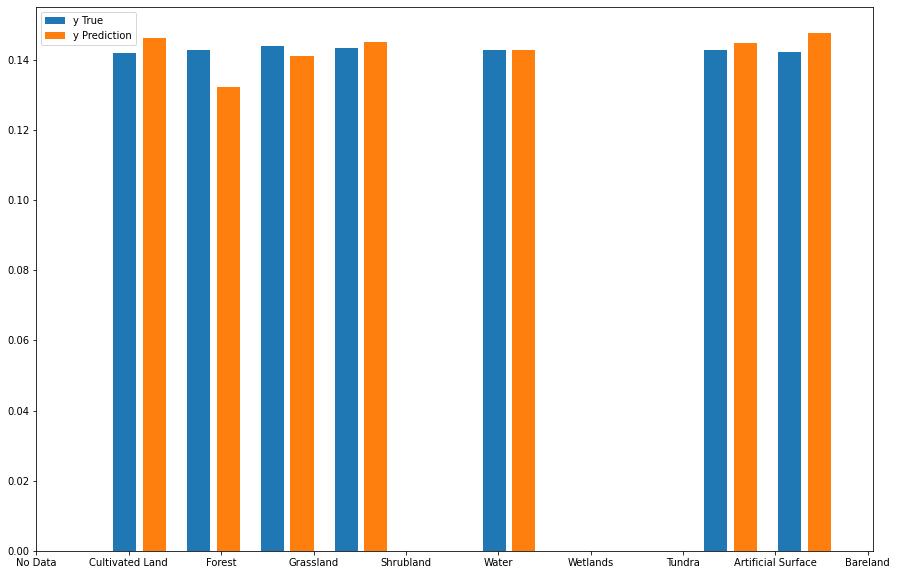

In [ ]:
true = y_val
pred = cbm_predictions

plt.figure(figsize=[15, 10])
plt.hist([true, pred], width = 0.25, histtype='bar', weights=[(np.zeros_like(true) + 1. / true.size), (np.zeros_like(pred) + 1. / pred.size)], align='mid')
# plt.hist(pred, color = 'y', width = 0.25, histtype='bar')
classes = ['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland']
plt.legend(['y True', 'y Prediction'])

plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

For 1 Pixel + surrounding 9 Pixels approach:

In [ ]:
X_train_v2.shape

In [ ]:
# create model
cbm_v2 = CatBoostClassifier(learning_rate=0.1, iterations=1000, random_seed=0, logging_level='Verbose', task_type="GPU")

# fit model
cbm_v2.fit(X_train_v2, y_train_v2)

In [ ]:
# Predict labels for test data
cbm_predictions_v2 = cbm_v2.predict(X_val_v2)

# Accuracy and Classification Report
print(f"Accuracy: {accuracy_score(y_val_v2, cbm_predictions_v2)*100}")
print(f"F1-Score: {f1_score(y_val_v2, cbm_predictions_v2, average=None)*100}")
print(classification_report(y_val_v2, cbm_predictions_v2))

# **Run on Testdataset:**

In [ ]:
#Predict values
#print(X_test)
#cbm_predictions_testset_probabilities = cbm.predict(X_test)
#cbm_predictions_testset = np.argmax(cbm_predictions_testset_probabilities, axis=1)
cbm_predictions_testset = cbm.predict(X_test)

In [ ]:
cbm_predictions_testset
cbm_predictions_testset.reshape(250000)
cbm_pred_corrected = np.array([x - 1 for x in cbm_predictions_testset.reshape(cbm_predictions_testset.shape[0])])

In [ ]:
np.histogram(cbm_pred_corrected, bins=list(range(len(classes_without_no_data) )))

(array([114676,  57495,  43634,   6556,     41,      0,      0,  27553,
            45]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

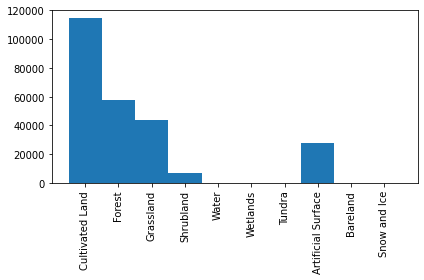

In [ ]:
##Plot predictions:

#
# Predicted class distribution:
plt.hist(cbm_pred_corrected, bins=list(range(len(classes_without_no_data) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes_without_no_data))))), labels=classes_without_no_data, rotation=90)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


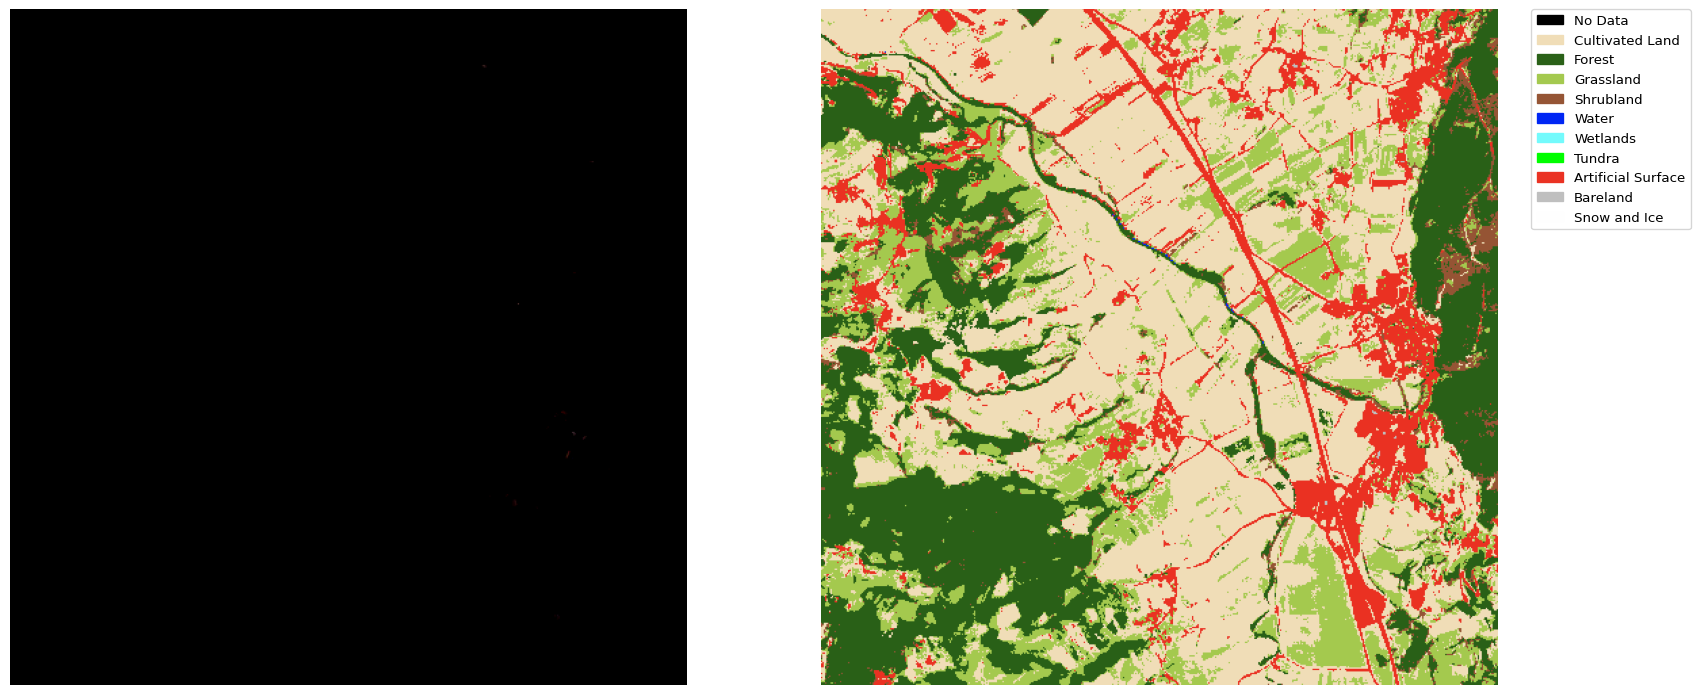

In [ ]:
show_result(cbm_predictions_testset.reshape(500, 500), X_test_raw_shape)



# **Predefined functions:**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# define all classes with their label and color
classes = [{  # Index 0
    "label": "No Data",
    "color": [0, 0, 0, 1]
}, {  # Index 1
    "label": "Cultivated Land",
    "color": [241/256, 222/256, 184/256, 1]
}, {  # Index 2
    "label": "Forest",
    "color": [42/256, 97/256, 24/256, 1]
}, {  # Index 3
    "label": "Grassland",
    "color": [165/256, 202/256, 79/256, 1]
}, {  # Index 4
    "label": "Shrubland",
    "color": [150/256, 85/256, 53/256, 1]
}, {  # Index 5
    "label": "Water",
    "color": [0, 38/256, 245/256, 1]
}, {  # Index 6
    "label": "Wetlands",
    "color": [115/256, 251/256, 253/256, 1]
}, {  # Index 7
    "label": "Tundra",
    "color": [0, 255/256, 0, 1]
}, {  # Index 8
    "label": "Artificial Surface",
    "color": [235/256, 50/256, 35/256, 1]
}, {  # Index 9
    "label": "Bareland",
    "color": [192/256, 192/256, 192/256, 1]
}, {  # Index 10
    "label": "Snow and Ice",
    "color": [255/256, 255/256, 255/256, 1]
}
]

# function to map a classification result to a color


def class_to_color(label):
    if (label < len(classes)):
        return classes[label]["color"]
    return [0, 0, 0]


def show_result(result, X_image):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20), dpi=96)

    # Plot correct image:
    # Load September
    band_sep = X_image[2, :, :, :3]
    # Flip from BGR to RGB
    band_flip = np.flip(band_sep, -1)
    # Change Contrast
    c_fact = 2.5
    band = 0.5 + c_fact * (band_flip - 0.5)

    ax1.axis('off')
    ax1.imshow(band, cmap='gray')

    # Plot prediction
    image = np.empty((result.shape[0], result.shape[1], 4))
    for i in range(0, result.shape[0]):
        for j in range(0, result.shape[1]):
            image[i, j] = class_to_color(result[i, j].astype(int))
    ax2.axis('off')
    im_ax2 = ax2.imshow(image)

    # Generate legend for prediction
    label_colors = [classes[i]['color'] for i in range(len(classes))]
    label_title = [classes[i]['label'] for i in range(len(classes))]
    # create a patch (proxy artist) for every color
    patches = [mpatches.Patch(color=label_colors[i], label=label_title[i])
               for i in range(len(label_title))]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(
        1.05, 1), loc=2, borderaxespad=0.)

    return plt.show()
# count the different classes in one result


def summarize_result(result):
    unique, counts = np.unique(result, return_counts=True)
    unique_int = unique.astype(int)

    res = dict()
    for i in range(0, unique_int.size):
        index = unique_int[i]
        count = counts[i]
        label = classes[index]["label"]
        res[label] = count

    sorted_res = dict(
        sorted(res.items(), key=lambda item: item[1], reverse=True))
    return sorted_res


def single_hist(a: np.array):
    label_title = [classes[i]['label'] for i in range(len(classes))]
    plt.hist(a, bins=list(range(len(classes) + 1)))
    plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))),
               labels=label_title, rotation=90)
    plt.tight_layout()
    plt.show()

def eval_hist(true: np.array, pred: np.array):
    label_title = [classes[i]['label'] for i in range(len(classes))]
    plt.figure(figsize=[15, 10])
    plt.hist([true, pred], width=0.25, histtype='bar', weights=[(np.zeros_like(
        true) + 1. / true.size), (np.zeros_like(pred) + 1. / pred.size)], align='mid')
    plt.legend(['y True', 'y Prediction'])
    plt.xticks([i + 0.25 for i in range(len(label_title))], label_title)
    plt.show()